# How this works:

Combine data from
1. Daily stock movement (download with rapidapi)
2. Insider trades scraped from openinsider
3. Articles from yahoo finance, graded as either positive neutral or negative through a huggingface NLP model aggregated into a daily sentiment

Todo: Merge it all together and feed into an LSTM model

# Initialize

In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import assets.config as config
import matplotlib.pyplot as plt
import csv
from datetime import datetime
import re
import time
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import time
import os

In [ ]:
ticker = 'SNOW'

### 1. Daily Info

In [16]:
if os.path.exists(f'data/{ticker}_daily.csv'):
    print('File exists')
else:
    # Define the URL and headers
    url = f"https://yahoo-finance127.p.rapidapi.com/historic/{ticker}/1d/730d"
    headers = {
        "x-rapidapi-key": "dfbe7c0a1fmshe393d06dc43c773p13ef07jsnc9ba1900f6ce",
        "x-rapidapi-host": "yahoo-finance127.p.rapidapi.com"
    }

    # Make the request
    response = requests.get(url, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        # Extract JSON data
        data = response.json()

        # Extract data
        timestamps = data['timestamp']
        close_prices = data['indicators']['quote'][0]['close']
        volumes = data['indicators']['quote'][0]['volume']

        # Convert timestamps to "yyyy-mm-dd" format
        dates = [datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d') for ts in timestamps]

        # Prepare data for CSV
        csv_data = list(zip(dates, close_prices, volumes))

        # Define CSV file path
        csv_file_path = f'data/{ticker}_daily.csv'

        # Write to CSV file
        with open(csv_file_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Date', 'Close', 'Volume'])  # Header row
            writer.writerows(csv_data)

        print(f"Data written to {csv_file_path}")
    else:
        print("Error:", response.status_code)

Data written to data/SNOW_daily.csv


In [ ]:
# Alphavantage implementation

# url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={ticker}&apikey={config.alphavantage_apikey}'
# r = requests.get(url)
# data = r.json()

# header = list(data['Time Series (Daily)']['2024-05-14'].keys())
# header.insert(0, 'Date')

# # Writing to CSV
# with open(f'data/{ticker}_daily.csv', 'w', newline='') as csvfile:
#     writer = csv.DictWriter(csvfile, fieldnames=header)
    
#     writer.writeheader()
    
#     for date, values in data['Time Series (Daily)'].items():
#         row = {'Date': date}
#         row.update(values)
#         writer.writerow(row)


### 2. Insider Trades

In [ ]:
url = f"http://openinsider.com/screener?s={ticker}&o=&pl=&ph=&ll=&lh=&fd=730&fdr=&td=0&tdr=&fdlyl=&fdlyh=&daysago=&xp=1&xs=1&vl=&vh=&ocl=&och=&sic1=-1&sicl=100&sich=9999&grp=0&nfl=&nfh=&nil=&nih=&nol=&noh=&v2l=&v2h=&oc2l=&oc2h=&sortcol=0&cnt=1000&page=1"

# Request the webpage
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

time.sleep(1)

# Find the table
table = soup.find('table', class_='tinytable')

if table:
    # Extract table rows
    rows = table.find_all('tr')

    # Create an empty list to store the data
    data = []

    # Loop through rows and extract data
    for row in rows[1:]:  # Skip the header row
        cells = row.find_all('td')
        insider_info = {
            'Trade Date': cells[2].get_text(strip=True),
            'Value': cells[11].get_text(strip=True)
        }
        data.append(insider_info)

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(data)

    # Remove dollar sign and comma from 'Value' column and convert to numeric type
    df['Value'] = df['Value'].str.replace('$', '').str.replace(',', '').astype(float)

    # Group the data by 'Trade Date' and aggregate the values
    df_merged = df.groupby('Trade Date').agg({'Value': 'sum'}).reset_index()

    # Save DataFrame to CSV
    df_merged.to_csv(f'data/{ticker}_insider_trades.csv', index=False)
    print('Insider trades data saved')

else:
    print('No table found')

### 3. Articles

Get articles

In [13]:
chrome_options = Options()
chrome_options.add_argument("--headless")
driver = webdriver.Chrome(options=chrome_options)

article_links = []

def get_yahoo_articles():
    driver.get(f"https://finance.yahoo.com/quote/{ticker}/news")

    # Scroll down the page multiple times to load more articles
    for _ in range(5): # scroll x times
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1)

    page_source = driver.page_source
    driver.quit()
    soup = BeautifulSoup(page_source, 'html.parser')

    articles = soup.find_all("li", class_="stream-item svelte-7rcxn")

    for article in articles:
        link = article.find("a").get("href")
        if '/news/' in link: article_links.append(link)
        
get_yahoo_articles()

print(article_links)

['https://finance.yahoo.com/news/snowflake-stock-cheapest-ever-time-102400046.html', 'https://finance.yahoo.com/news/better-ai-stock-palantir-vs-073400718.html', 'https://finance.yahoo.com/news/snowflake-working-beef-security-controls-201220398.html', 'https://finance.yahoo.com/news/most-watched-stock-snowflake-inc-130017953.html', 'https://finance.yahoo.com/news/snowflake-hit-data-breach-whats-141942232.html', 'https://finance.yahoo.com/news/diversify-beyond-nvidia-3-artificial-113000946.html', 'https://finance.yahoo.com/news/buy-mongodb-snowflake-atlassian-52-092300920.html', 'https://finance.yahoo.com/news/databricks-ceo-ali-ghosdi-snowflake-104622130.html', 'https://finance.yahoo.com/news/30-billion-lost-market-value-190952486.html', 'https://finance.yahoo.com/news/snowflake-brings-industry-leading-enterprise-161000062.html', 'https://finance.yahoo.com/news/snowflake-doubles-down-developers-end-160500005.html', 'https://finance.yahoo.com/news/snowflake-ceo-seeking-ai-deals-16000024

In [ ]:
article_links = ['https://finance.yahoo.com/news/snowflake-inc-snow-rises-higher-214519243.html']

In [14]:
import time
import pandas as pd
import requests
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import re
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor

# Function to measure runtime
def measure_time(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Function {func.__name__} took {end_time - start_time:.2f} seconds")
        return result
    return wrapper

@measure_time
def scrape_yahoo_finance(url):
    # Define the path to the ChromeDriver executable directly
    chromedriver_path = 'assets/chromedriver'  # Adjust to 'assets/chromedriver.exe' on Windows if necessary

    # Set up Selenium WebDriver
    service = Service(chromedriver_path)
    options = webdriver.ChromeOptions()
    options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36')
    options.add_argument('--headless')  # Run in headless mode
    options.add_argument('--disable-gpu')  # Disable GPU acceleration
    options.add_argument('--no-sandbox')  # Bypass OS security model
    options.add_argument('--disable-dev-shm-usage')  # Overcome limited resource problems
    # Disable images to speed up page load
    prefs = {"profile.managed_default_content_settings.images": 2}
    options.add_experimental_option("prefs", prefs)

    driver = webdriver.Chrome(service=service, options=options)
    driver.get(url)

    try:
        # Wait until the element is present
        WebDriverWait(driver, 5).until(
            EC.presence_of_element_located((By.ID, "caas-lead-header-undefined"))
        )

        # Get page source and parse with BeautifulSoup
        soup = BeautifulSoup(driver.page_source, 'html.parser')

        # Get header
        header_element = soup.find(id="caas-lead-header-undefined")
        header = header_element.get_text().strip() if header_element else "N/A"

        # Get body
        article_elements = soup.find_all(class_="caas-body")
        body = ""
        for element in article_elements:
            body += element.get_text().strip() + "\n"

        # Get date
        date_text = soup.find_all(class_="caas-attr-time-style")[0].get_text().strip()
        date = re.search(r'(\w{3}, \w{3} \d{1,2}, \d{4})', date_text)
        date = datetime.strptime(date.group(), "%a, %b %d, %Y").strftime("%Y-%m-%d") if date else "N/A"

        return header, body, date
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None, None
    finally:
        driver.quit()

def analyze(text):
    # Summarizer
    summarizer_api_url = "https://api-inference.huggingface.co/models/sshleifer/distilbart-cnn-12-6"
    summarizer_headers = {"Authorization": f"Bearer {config.huggingface_apikey}"}
    summarizer_output = requests.post(summarizer_api_url, headers=summarizer_headers, json={"inputs": text}).json()
    text = summarizer_output[0]['summary_text']

    # Sentimentizer
    sentimentizer_api_url = "https://api-inference.huggingface.co/models/ProsusAI/finbert"
    sentimentizer_headers = {"Authorization": f"Bearer {config.huggingface_apikey}"}
    sentimentizer_output = requests.post(sentimentizer_api_url, headers=sentimentizer_headers, json={"inputs": text}).json()

    most_likely_label, max_score = None, 0
    for sentiment in sentimentizer_output[0]:
        label, score = sentiment['label'], sentiment['score']
        if score > max_score:
            most_likely_label, max_score = label, score
    if most_likely_label == 'positive':
        sentiment = 1
    elif most_likely_label == 'neutral':
        sentiment = 0
    else:
        sentiment = -1

    return sentiment, summarizer_output, sentimentizer_output

# Parallel scraping function
def scrape_multiple_articles(urls):
    with ThreadPoolExecutor(max_workers=5) as executor:
        results = list(executor.map(scrape_yahoo_finance, urls))
    return results

# Main engine
articledata = []
company_table = pd.read_csv('assets/companies.csv')
short_name, company_name = company_table.loc[company_table['ticker'] == ticker]['short name'].values[0], company_table.loc[company_table['ticker'] == ticker]['company name'].values[0]

# Scrape articles
results = scrape_multiple_articles(article_links)
for i, (head, body, date) in enumerate(results):
    if head is None or body is None or date is None:
        continue
    
    if ticker in head or short_name in head or company_name in head:
        pass
    else:
        continue

    try:
        sentiment, summarizer_output, sentimentizer_output = analyze(body)
    except Exception as sentiment_error:
        print(f"Failed to analyze sentiment for article '{article_links[i]}': {sentiment_error.__class__.__name__}: {str(sentiment_error)} \n")
        continue

    articledata.append({'Date': date, 'Sentiment': sentiment})
    print(f"Iteration {i}: {date}, '{head}'\n- {article_links[i]}\n- Summarizer output: {summarizer_output[0]['summary_text']}\n- Sentimentizer output: {sentimentizer_output[0][0]['label']} ({round(sentimentizer_output[0][0]['score'], 2)})\n")

df = pd.DataFrame(articledata)

df['Negative_Count'] = (df['Sentiment'] == -1).astype(int)
df['Neutral_Count'] = (df['Sentiment'] == 0).astype(int)
df['Positive_Count'] = (df['Sentiment'] == 1).astype(int)
df['Negative_Count'] *= -1

# Group by date and sum the counts
df_grouped = df.groupby('Date').agg({'Negative_Count': 'sum', 'Neutral_Count': 'sum', 'Positive_Count': 'sum'}).reset_index()
df_grouped['Total_Count'] = df_grouped['Negative_Count'] + df_grouped['Positive_Count']

df_grouped.to_csv(f'data/{ticker}_sentiment.csv', index=False)

print("Success")


Function scrape_yahoo_finance took 10.54 seconds
Function scrape_yahoo_finance took 8.95 seconds
Function scrape_yahoo_finance took 8.52 seconds
Function scrape_yahoo_finance took 83.24 seconds
Function scrape_yahoo_finance took 84.02 seconds
Function scrape_yahoo_finance took 85.67 seconds
Function scrape_yahoo_finance took 86.52 seconds
Function scrape_yahoo_finance took 9.58 seconds
Function scrape_yahoo_finance took 82.21 seconds
Function scrape_yahoo_finance took 83.87 seconds
Function scrape_yahoo_finance took 82.76 seconds
Function scrape_yahoo_finance took 83.02 seconds
Function scrape_yahoo_finance took 81.52 seconds
Function scrape_yahoo_finance took 8.47 seconds
Function scrape_yahoo_finance took 7.34 seconds
Function scrape_yahoo_finance took 83.81 seconds
Function scrape_yahoo_finance took 8.49 seconds
Function scrape_yahoo_finance took 81.97 seconds
Function scrape_yahoo_finance took 83.41 seconds
Function scrape_yahoo_finance took 83.36 seconds
Function scrape_yahoo_fina

In [ ]:
def scrape_yahoo_finance(url):
    response = requests.get(url)
    print(response)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')

        # Get header
        header_element = soup.find(id="caas-lead-header-undefined")
        header = header_element.get_text().strip()

        # Get body
        article_elements = soup.find_all(class_="caas-body")
        body = ""
        for element in article_elements: body += element.get_text().strip() + "\n"

        # Get date
        date_text = soup.find_all(class_="caas-attr-time-style")[0].get_text().strip()
        date = re.search(r'(\w{3}, \w{3} \d{1,2}, \d{4})', date_text)
        date = datetime.strptime(date.group(), "%a, %b %d, %Y").strftime("%Y-%m-%d")

        return header, body, date
    else:
        print("Failed to retrieve the webpage. Status code:", response.status_code)

def analyze(text):
    # Summarizer
    summarizer_api_url = "https://api-inference.huggingface.co/models/sshleifer/distilbart-cnn-12-6"
    summarizer_headers = {f"Authorization": f"Bearer {config.huggingface_apikey}"}
    summarizer_output = requests.post(summarizer_api_url, headers=summarizer_headers, json={"inputs": text}).json()
    text = summarizer_output[0]['summary_text']

    # Sentimentizer
    sentimentizer_api_url = "https://api-inference.huggingface.co/models/ProsusAI/finbert"

    # ----- New model below, might use this since finbert has problems
    # https://huggingface.co/mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis???????

    sentimentizer_headers = {"Authorization": f"Bearer {config.huggingface_apikey}"}
    sentimentizer_output = requests.post(sentimentizer_api_url, headers=sentimentizer_headers, json={"inputs": text}).json()

    most_likely_label, max_score = None, 0
    for sentiment in sentimentizer_output[0]:
        label, score = sentiment['label'], sentiment['score']
        if score > max_score: most_likely_label, max_score = label, score
    if most_likely_label == 'positive': sentiment = 1
    elif most_likely_label == 'neutral': sentiment = 0
    else: sentiment = -1

    return sentiment, summarizer_output, sentimentizer_output

# Main engine
articledata = []
company_table = pd.read_csv('assets/companies.csv')
short_name, company_name = company_table.loc[company_table['ticker'] == ticker]['short name'].values[0], company_table.loc[company_table['ticker'] == ticker]['company name'].values[0]

for i, article in enumerate(article_links):
    try: 
        head, body, date = scrape_yahoo_finance(article)
        if ticker in head or short_name in head or company_name in head: pass
        else: continue
    except Exception as scrape_error:
        print(f"Failed to scrape article '{article}': {scrape_error.__class__.__name__}: {str(scrape_error)} \n")

        continue

    try: 
        sentiment, summarizer_output, sentimentizer_output = analyze(body)
    except Exception as sentiment_error:
        print(f"Failed to analyze sentiment for article '{article}': {sentiment_error.__class__.__name__}: {str(sentiment_error)} \n")
        continue

    articledata.append({'Date': date, 'Sentiment': sentiment})
    print(f"Iteration {i}: {date}, '{head}'\n- {article}\n- Summarizer output:{summarizer_output[0]['summary_text']}\n- Sentimentizer output: {sentimentizer_output[0][0]['label']} ({round(sentimentizer_output[0][0]['score'], 2)})\n")

df = pd.DataFrame(articledata)

df['Negative_Count'] = (df['Sentiment'] == -1).astype(int)
df['Neutral_Count'] = (df['Sentiment'] == 0).astype(int)
df['Positive_Count'] = (df['Sentiment'] == 1).astype(int)
df['Negative_Count'] *= -1

# Group by date and sum the counts
df_grouped = df.groupby('Date').agg({'Negative_Count': 'sum', 'Neutral_Count': 'sum', 'Positive_Count': 'sum'}).reset_index()
df_grouped['Total_Count'] = df_grouped['Negative_Count'] + df_grouped['Positive_Count']

df_grouped.to_csv(f'data/{ticker}_sentiment.csv', index=False)

print("Success")

# Merge

In [33]:
historical = pd.read_csv(f'data/{ticker}_daily.csv')
insider = pd.read_csv(f'data/{ticker}_insider_trades.csv')
news = pd.read_csv(f'data/{ticker}_sentiment.csv')

newdata = pd.merge(historical, insider, how='left', left_on='Date', right_on='Trade Date')
newdata = pd.merge(newdata, news, how='left', on='Date')
newdata['Date'] = pd.to_datetime(newdata['Date'])

# Alphavantage technique: newdata.rename(columns={'4. close': 'Close', '5. volume': 'Volume', 'Value': 'Insider_Trades'}, inplace=True)
# Alphavantage technique: newdata = newdata.drop(columns=['1. open', '2. high', '3. low', 'Trade Date'])
newdata.rename(columns={'Value': 'Insider_Trades'}, inplace=True)
newdata = newdata.fillna(0)
newdata['Close_Delta'] = newdata['Close'] - newdata['Close'].shift(1)
# newdata['Total_Count_Delta'] = newdata['Total_Count'] - newdata['Total_Count'].shift(1)
# newdata['Insider_Trades'] = newdata['Insider_Trades'].fillna(0)

newdata = newdata.drop(columns=['Trade Date'])

newdata.to_csv(f'data/{ticker}_merged.csv', index=True)

print(newdata.head)

<bound method NDFrame.head of           Date       Close    Volume  Insider_Trades  Negative_Count  \
0   2021-07-15  251.000000   3342500             0.0             0.0   
1   2021-07-16  250.820007   2255100             0.0             0.0   
2   2021-07-19  252.279999   2338800             0.0             0.0   
3   2021-07-20  256.269989   1659700             0.0             0.0   
4   2021-07-21  259.299988   1939100             0.0             0.0   
..         ...         ...       ...             ...             ...   
725 2024-06-03  136.929993   7549700             0.0             0.0   
726 2024-06-04  137.000000   7627400      -2057100.0            -1.0   
727 2024-06-05  134.289993  15919800             0.0             0.0   
728 2024-06-06  132.039993   8261000             0.0            -2.0   
729 2024-06-07  131.210007   4346900             0.0            -1.0   

     Neutral_Count  Positive_Count  Total_Count  Close_Delta  
0              0.0             0.0        

# Visualize

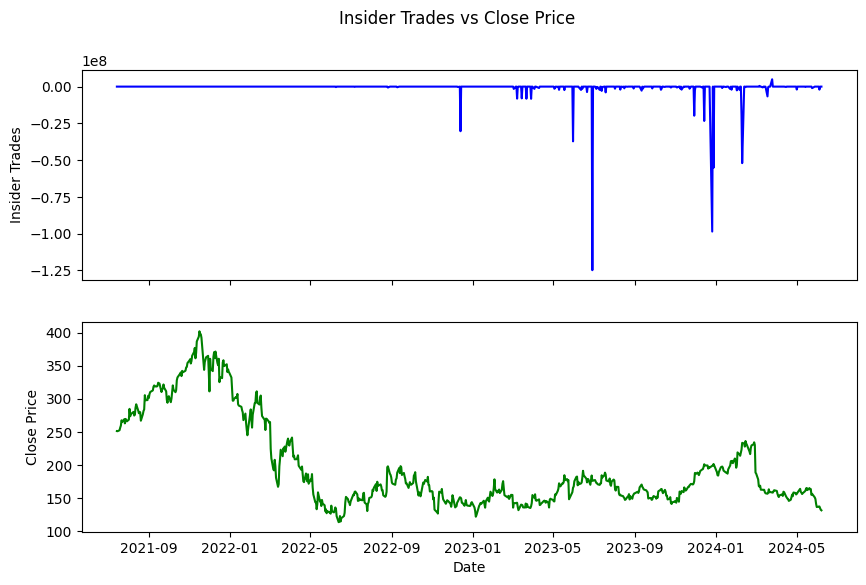

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax1.plot(newdata['Date'], newdata['Insider_Trades'], color='blue')
ax2.plot(newdata['Date'], newdata['Close'], color='green')

ax1.set_ylabel('Insider Trades')
ax2.set_ylabel('Close Price')
ax2.set_xlabel('Date')
plt.suptitle('Insider Trades vs Close Price')

plt.show()

35


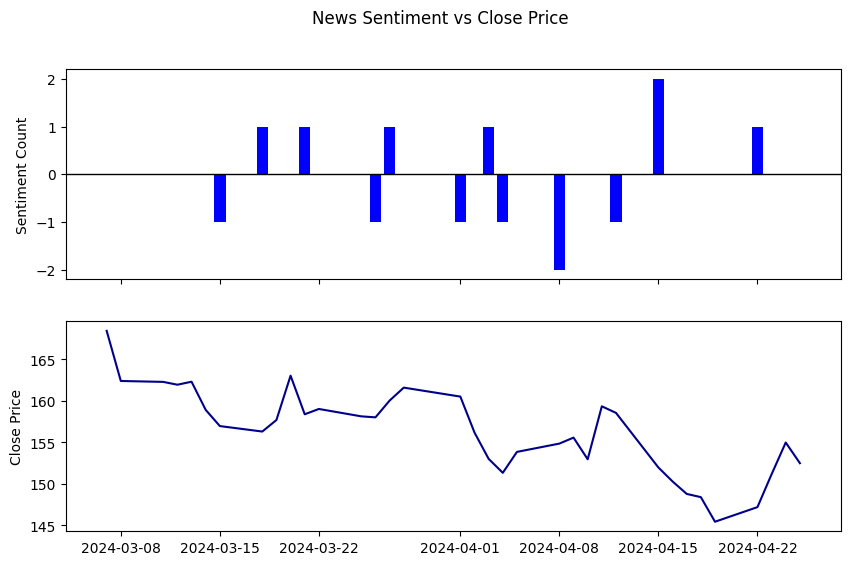

In [71]:
data = pd.read_csv(f'data/{ticker}_merged.csv')
data = data[-65:-30]
data['Date'] = pd.to_datetime(data['Date'])

print(len((data)))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax1.axhline(0, color='Black', linewidth=1)
ax1.bar(data['Date'], data['Total_Count'], color='blue', align='center', label='Overall Sentiment')
ax2.plot(data['Date'], data['Close'], color='darkblue', label='Close Price')

plt.suptitle('News Sentiment vs Close Price')
ax1.set_ylabel('Sentiment Count')
ax2.set_ylabel('Close Price')

plt.show()

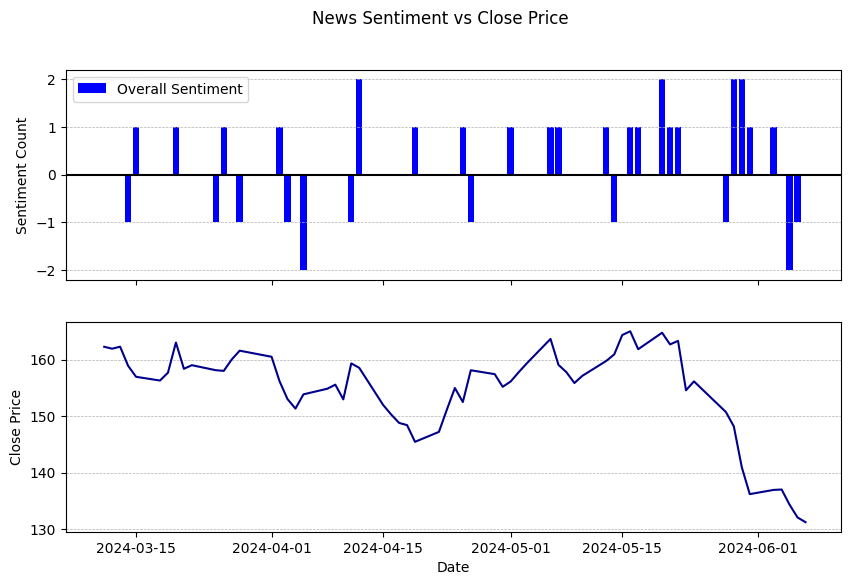

In [75]:
# print(newdata['Close'], newdata['Total_Count'])
# print(np.corrcoef(newdata['Close'], newdata['Total_Count'])[0, 1])
# print(newdata['Date'][::-1][:(int(len(news) * 1.2))])
newdata = pd.read_csv(f'data/{ticker}_merged.csv')
newdata = newdata[::-1][:int(len(news) * 1.2)]
# print(newdata['Total_Count'])
newdata['Total_Count'] = newdata['Total_Count'].shift(periods=1)
newdata['Negative_Count'] = newdata['Total_Count'].shift(periods=1)
newdata['Positive_Count'] = newdata['Total_Count'].shift(periods=1)
# print(newdata)[:5]

# Convert 'Date' column to datetime
newdata['Date'] = pd.to_datetime(newdata['Date'])

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# ax1.bar(newdata['Date'], newdata['Negative_Count'], color='red', align='center', label='Negative Sentiment')
# ax1.bar(newdata['Date'], newdata['Positive_Count'], color='green', align='center', label='Positive Sentiment')
ax1.bar(newdata['Date'], newdata['Total_Count'], color='blue', align='center', label='Overall Sentiment')

# Add horizontal gridlines to the top chart
ax1.grid(which='major', axis='y', linestyle='--', linewidth=0.5)
ax2.grid(which='major', axis='y', linestyle='--', linewidth=0.5)
ax1.axhline(0, color='black')

# Plot Close Price
ax2.plot(newdata['Date'], newdata['Close'], color='darkblue', label='Close Price')

# Set y-axis labels
ax1.set_ylabel('Sentiment Count')
ax2.set_ylabel('Close Price')

# Set x-axis label
ax2.set_xlabel('Date')

# Add legend to ax1
ax1.legend()

# Set title for the entire plot
plt.suptitle('News Sentiment vs Close Price')

# Show plot
plt.show()

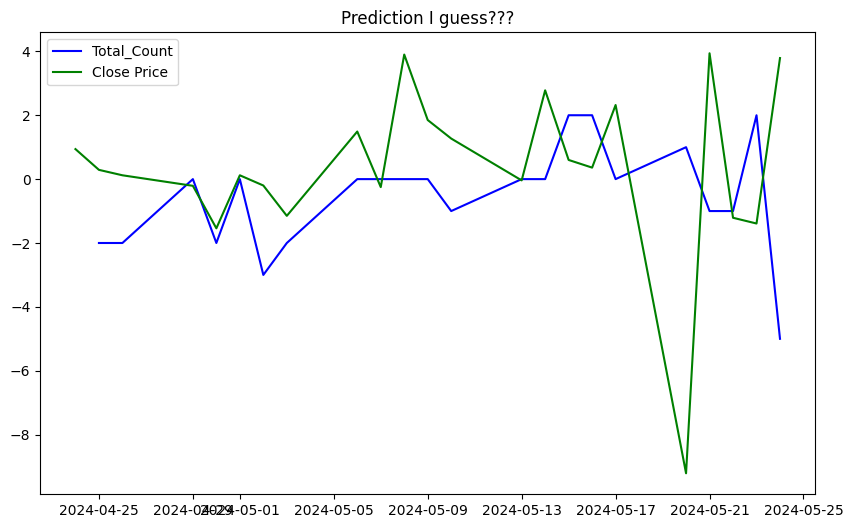

In [76]:
# Load the data
data_path = 'subset.csv'
newdata = pd.read_csv(data_path)
# print(newdata)

newdata['Date'] = pd.to_datetime(newdata['Date'])

newdata['Total_Count'] = newdata['Total_Count'].shift(1)

plt.figure(figsize=(10, 6))
plt.plot(newdata['Date'], newdata['Total_Count'], label='Total_Count', color='blue')
plt.plot(newdata['Date'], newdata['Close_Delta'], label='Close Price', color='green')
plt.legend()
plt.title('Prediction I guess???')
plt.show()


Jane Street if you see this hire me 🙏